In [1]:
from typing import Dict
import numpy as np
import pandas as pd

import ydata_profiling
import scienceplots
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

%matplotlib inline

pd.plotting.register_matplotlib_converters()
plt.style.use(['fivethirtyeight', 'science', 'grid'])
sns.set(
    rc={'text.usetex': True},
    font="serif",
    font_scale=1.2
)


In [2]:
# 辅助表格，给出4214个常用APP所属类别
app = pd.read_csv('../Datasets/app_class.csv', header=None)
app.columns = ['appid', 'app_class']
print('app:', app.shape)

# 某年连续30天的4万多智能手机用户的监测数据
# 初赛数据集，仅含1～21天
day: Dict[int, pd.DataFrame] = {}
for i in range(1, 2):
    # 读取数据，增加列标签，便于索引
    day[i] = pd.read_csv(f'../Datasets/day{str(i).zfill(2)}.txt', header=None)
    day[i].columns = ['uid', 'appid', 'app_type', 'start_day', 'start_time',
                      'end_day', 'end_time', 'duration', 'up_flow', 'down_flow']

    # 数据融合：将辅助表格链接至每日监测数据表格
    day[i] = day[i].merge(app, on='appid', how='left')

    # 数据清洗：仅保留使用时长小于一天（24*60*60秒）的资料
    # 1～7天中，平均每日有15条异常值
    # TODO: 验证duration是否计算错误。
    day[i] = day[i].query('duration <= 86400')

    # 数据清洗：仅保留已知所属类别的常用APP，遗弃其余不常用APP
    # TODO: 验证NaN是否存在语义信息。
    day[i].dropna(inplace=True, axis='index')
    print(f'day{str(i).zfill(2)}:', day[i].shape)


app: (4214, 2)
day01: (3178319, 11)


In [24]:
pivot_table = day[1].pivot_table(
    index='uid',
    columns='app_class',
    values='duration',
    aggfunc=np.sum,
    fill_value=0
)


pivot_table


app_class,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t
uid,,,,,,,,,,,,,,,,,,,,
0000348F61881026FE0036840F25309F,0,0,0,170,1013,4719,0,0,0,0,1,0,0,142,0,12713,0,0,322,0
00028CD7D203AF88C4FE4D0A83A0016E,50,113,12861,383,0,1675,253,0,0,0,7,0,0,161,0,0,0,0,0,859
000343EFFAAF27FE66CAD41434814C71,0,0,29,0,237,195,0,0,84,0,664,0,0,0,0,0,0,0,0,0
00046AA87AAF8C9971F99597ED7D90DF,76,0,0,0,474,199,5,0,0,0,0,0,0,0,0,0,0,0,0,0
00050A1B07C0BD248726E0385D04D657,188,0,0,561,0,11,8,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FFF62C1EEF706DF3174EF676391E15C1,0,0,0,0,3014,0,0,0,406,0,0,0,0,0,0,0,0,0,0,0
FFF6689AA115DFBAA4A6D66928F93971,0,0,0,2662,119,2559,11,0,0,0,0,0,0,0,0,0,0,0,0,0
FFF82C898EE523DA1F4137097FECCB20,0,0,0,0,1343,2477,5,0,0,0,211,0,0,233,419,61,0,0,0,0


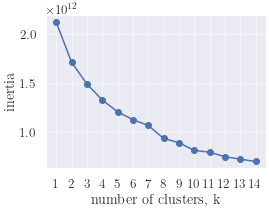

In [29]:
from sklearn.cluster import KMeans

X = pivot_table
ks = range(1, 15)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, random_state=0, n_init="auto")

    # Fit model to samples
    model.fit(X)

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()
